## Train the CNN as per the paper
This notebook implements what the paper does. First SCAE to get representative image and then use CNN.

In [8]:
import sys
import os

sys.path.append(os.path.abspath('..'))

from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

from lib.CustomDatasets import SCAEDataset
from lib.Models import StackedConvAutoencoder, ArtifactCNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torch.manual_seed(6)
model.to(device)



ArtifactCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [2]:
train_dataset = SCAEDataset(root_dir="../data/abp/train")
val_dataset = SCAEDataset(root_dir="../data/abp/val")
test_dataset = SCAEDataset(root_dir="../data/abp/test")

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)

In [3]:
SCAEModel = StackedConvAutoencoder()

#Load the best model while training the AE
SCAEModel.load_state_dict(torch.load('../models/SCAE_best.pth'))
SCAEModel.to(device)
SCAEModel.eval()

StackedConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [4]:
num_classes = 2
model = ArtifactCNN(num_classes=num_classes)
print(model)

ArtifactCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [5]:
## Verifying sizes of each layer outputs
dummy_input = torch.randn(32, 1, 64, 64)

# Function to calculate the size of each layer's output
def calculate_layer_sizes(model, dummy_input):
    layer_sizes = []
    x = dummy_input
    for layer in model.children():
        x = layer(x)
        if isinstance(layer, nn.Flatten):
            layer_sizes.append(x.shape[1])  # After flattening, x is a 1D tensor
        else:
            layer_sizes.append(x.size())
    return layer_sizes

layer_sizes = calculate_layer_sizes(model, dummy_input)
layer_sizes

[torch.Size([32, 16, 32, 32]),
 torch.Size([32, 16, 16, 16]),
 torch.Size([32, 32, 16, 16]),
 8192,
 torch.Size([32, 128]),
 torch.Size([32, 128]),
 torch.Size([32, 2])]

In [12]:
# Train the CNN
# Define the loss function and optimizer
train_loss_arr, val_loss_arr = [],[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 100  # Number of training epochs
best_val_loss = float('inf')  # Track the best validation loss

# Training and Validation
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        inputs_recon = SCAEModel(inputs)
        
        
        # Forward + backward + optimize
        outputs = model(inputs_recon)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')
    
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            inputs_recon = SCAEModel(inputs)

            outputs = model(inputs_recon)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
    
    train_loss_arr.append(avg_train_loss)
    val_loss_arr.append(avg_val_loss)
    
    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.4f}--->{avg_val_loss:.4f}) \t Saving The Model')
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '../models/CNN_best_model.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.3340
Epoch 1, Validation Loss: 0.3552
Validation Loss Decreased(inf--->0.3552) 	 Saving The Model
Epoch 2, Train Loss: 0.3338
Epoch 2, Validation Loss: 0.3545
Validation Loss Decreased(0.3552--->0.3545) 	 Saving The Model
Epoch 3, Train Loss: 0.3331
Epoch 3, Validation Loss: 0.3547
Epoch 4, Train Loss: 0.3332
Epoch 4, Validation Loss: 0.3552
Epoch 5, Train Loss: 0.3334
Epoch 5, Validation Loss: 0.3557
Epoch 6, Train Loss: 0.3333
Epoch 6, Validation Loss: 0.3538
Validation Loss Decreased(0.3545--->0.3538) 	 Saving The Model
Epoch 7, Train Loss: 0.3329
Epoch 7, Validation Loss: 0.3550
Epoch 8, Train Loss: 0.3325
Epoch 8, Validation Loss: 0.3548
Epoch 9, Train Loss: 0.3323
Epoch 9, Validation Loss: 0.3554
Epoch 10, Train Loss: 0.3324
Epoch 10, Validation Loss: 0.3566
Epoch 11, Train Loss: 0.3324
Epoch 11, Validation Loss: 0.3526
Validation Loss Decreased(0.3538--->0.3526) 	 Saving The Model
Epoch 12, Train Loss: 0.3324
Epoch 12, Validation Loss: 0.3543
Epoch 13, Tra

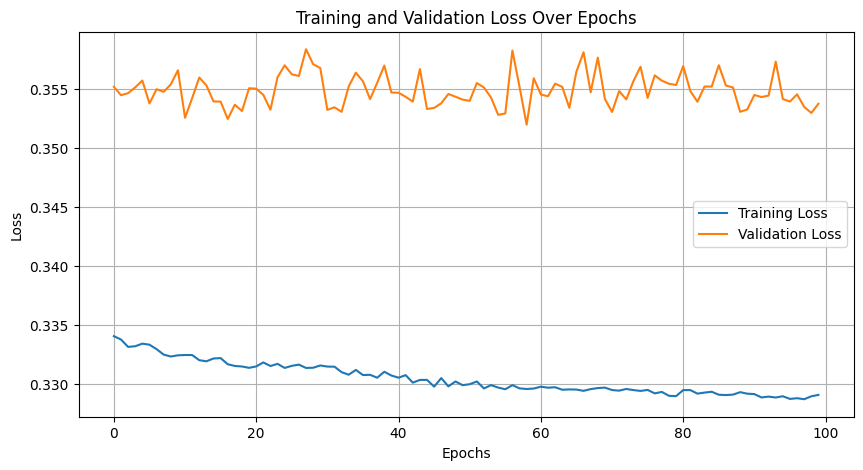

In [13]:
import matplotlib.pyplot as plt
# Plotting both training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_arr, label='Training Loss')
plt.plot(val_loss_arr, label='Validation Loss')

# Labeling the graph
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Load the best performing model
model.load_state_dict(torch.load('../models/CNN_best_model.pth'))

<All keys matched successfully>

In [6]:
def evaluate_model(model, loader):
    # Ensure the model is in evaluation mode
    actual_labels = []
    predicted_labels = []
    
    model.eval()

    # Disable gradient calculation for efficiency and to prevent changes to the model
    with torch.no_grad():
        correct = 0
        total = 0
        
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device)

            inputs_recon = SCAEModel(inputs)
            
            # Forward pass
            outputs = model(inputs_recon)
            
            # Convert outputs probabilities to predicted class
            _, predicted = torch.max(outputs.data, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            actual_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())
    
    return actual_labels, predicted_labels


In [9]:
actual, predicted = evaluate_model(model, test_loader)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# Calculate Accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 Score: F1 Score is the weighted average of Precision and Recall.
f1 = f1_score(actual, predicted)

# Calculate G-Score: G-Score is the geometric mean of Precision and Sensitivity (Recall).
precision = precision_score(actual, predicted)
sensitivity = recall_score(actual, predicted)  # Also known as Recall
g_score = (precision * sensitivity)**0.5

# Calculate Net Prediction: (True Positives - False Positives) / Total Predictions
true_positives = sum((a == 1 and p == 1) for a, p in zip(actual, predicted))
false_positives = sum((a == 0 and p == 1) for a, p in zip(actual, predicted))
net_prediction = (true_positives - false_positives) / len(predicted)

# Calculate Specificity: True Negative Rate
true_negatives = sum((a == 0 and p == 0) for a, p in zip(actual, predicted))
specificity = true_negatives / sum(a == 0 for a in actual)

accuracy, f1, g_score , sensitivity, specificity

(0.9601352023063923,
 0.6309438592903159,
 0.674775481199067,
 0.9775031685678074,
 0.9595078683834048)

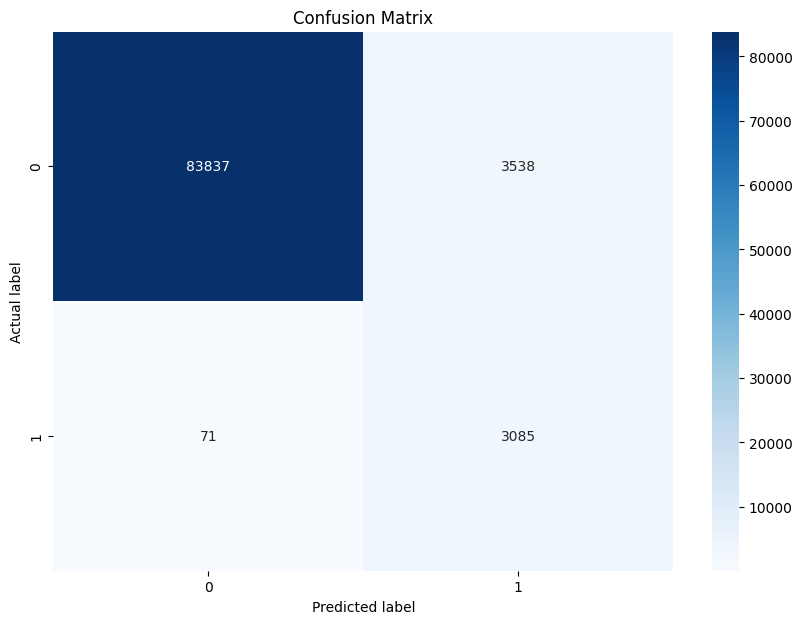

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

conf_matrix  = confusion_matrix(actual, predicted)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

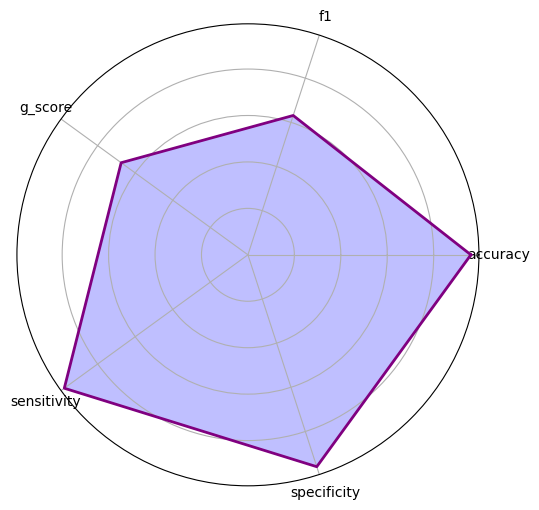

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
labels=np.array(['accuracy', 'f1', 'g_score' , 'sensitivity', 'specificity'])
stats=np.array([accuracy, f1, g_score , sensitivity, specificity])

# Number of variables
num_vars = len(labels)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop"
# and append the start value to the end.
stats=np.concatenate((stats,[stats[0]]))
angles+=angles[:1]

# Draw the outline of our data
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='blue', alpha=0.25)
ax.plot(angles, stats, color='purple', linewidth=2)

# Label each point with its variable name
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.show()

In [15]:
for metric, value in zip(labels, stats):
    print(f"{metric}: {round(value,4)}")

accuracy: 0.9601
f1: 0.6309
g_score: 0.6748
sensitivity: 0.9775
specificity: 0.9595


#### Verify the ablation by not using VAE

In [27]:
def evaluate_model_noAE(model, loader):
    # Ensure the model is in evaluation mode
    actual_labels = []
    predicted_labels = []
    
    model.eval()

    # Disable gradient calculation for efficiency and to prevent changes to the model
    with torch.no_grad():
        correct = 0
        total = 0
        
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device)

            # inputs_recon = SCAEModel(inputs)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert outputs probabilities to predicted class
            _, predicted = torch.max(outputs.data, 1)
            
            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            actual_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())
    
    return actual_labels, predicted_labels


In [29]:
# Train the CNN
# Define the loss function and optimizer

model = ArtifactCNN(num_classes=num_classes)

train_loss_arr, val_loss_arr = [],[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.to(device)

num_epochs = 100  # Number of training epochs
best_val_loss = float('inf')  # Track the best validation loss

# Training and Validation
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # inputs_recon = SCAEModel(inputs)

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')
    
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            # inputs_recon = SCAEModel(inputs)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
    
    train_loss_arr.append(avg_train_loss)
    val_loss_arr.append(avg_val_loss)
    
    # Save the model if validation loss has decreased
    if avg_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.4f}--->{avg_val_loss:.4f}) \t Saving The Model')
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '../models/CNN_best_model.pth')


model.load_state_dict(torch.load('../models/CNN_best_model.pth'))

actual, predicted = evaluate_model_noAE(model, test_loader)

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


# Calculate Accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 Score: F1 Score is the weighted average of Precision and Recall.
f1 = f1_score(actual, predicted)

# Calculate G-Score: G-Score is the geometric mean of Precision and Sensitivity (Recall).
precision = precision_score(actual, predicted)
sensitivity = recall_score(actual, predicted)  # Also known as Recall
g_score = (precision * sensitivity)**0.5

# Calculate Net Prediction: (True Positives - False Positives) / Total Predictions
true_positives = sum((a == 1 and p == 1) for a, p in zip(actual, predicted))
false_positives = sum((a == 0 and p == 1) for a, p in zip(actual, predicted))
net_prediction = (true_positives - false_positives) / len(predicted)

# Calculate Specificity: True Negative Rate
true_negatives = sum((a == 0 and p == 0) for a, p in zip(actual, predicted))
specificity = true_negatives / sum(a == 0 for a in actual)

accuracy, f1, g_score , sensitivity, specificity


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.8119
Epoch 1, Validation Loss: 0.8131
Validation Loss Decreased(inf--->0.8131) 	 Saving The Model
Epoch 2, Train Loss: 0.8133
Epoch 2, Validation Loss: 0.8136
Epoch 3, Train Loss: 0.8132
Epoch 3, Validation Loss: 0.8131
Validation Loss Decreased(0.8131--->0.8131) 	 Saving The Model
Epoch 4, Train Loss: 0.8133
Epoch 4, Validation Loss: 0.8144
Epoch 5, Train Loss: 0.8133
Epoch 5, Validation Loss: 0.8129
Validation Loss Decreased(0.8131--->0.8129) 	 Saving The Model
Epoch 6, Train Loss: 0.8134
Epoch 6, Validation Loss: 0.8129
Epoch 7, Train Loss: 0.8132
Epoch 7, Validation Loss: 0.8133
Epoch 8, Train Loss: 0.8133
Epoch 8, Validation Loss: 0.8131
Epoch 9, Train Loss: 0.8133
Epoch 9, Validation Loss: 0.8125
Validation Loss Decreased(0.8129--->0.8125) 	 Saving The Model
Epoch 10, Train Loss: 0.8133
Epoch 10, Validation Loss: 0.8129
Epoch 11, Train Loss: 0.8133
Epoch 11, Validation Loss: 0.8131
Epoch 12, Train Loss: 0.8133
Epoch 12, Validation Loss: 0.8131
Epoch 13, Tra

(0.5, 0.6666666666666666, 0.7071067811865476, 1.0, 0.0)